<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/gpt-neo/661_GPT_Neo_CARER_ZSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-Neo CARER
This notebook will prompt a pretrained GPT-Neo on the Contextualized Affect Representations for Emotion Recognition (CARER) dataset via Zero Shot Prompting.

## Setup

In [1]:
!pip install datasets transformers torch scikit-learn matplotlib seaborn

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Dataset and Model

In [2]:
dataset = load_dataset("dair-ai/emotion", split="test")
model_name = "EleutherAI/gpt-neo-2.7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

## Evaluation

In [8]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = f"Choose which emotion this text expresses from the following options: {','.join(emotions)}. Text: '{text}'. The emotion that best describes this text is:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...


## Graphs and Table

Zero-shot accuracy on the CARER dataset: 35.35%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.33      0.96      0.49       581
         joy       0.75      0.16      0.27       695
        love       0.57      0.10      0.17       159
       anger       0.91      0.04      0.07       275
        fear       1.00      0.00      0.01       224
    surprise       0.09      0.12      0.10        66

    accuracy                           0.35      2000
   macro avg       0.61      0.23      0.18      2000
weighted avg       0.64      0.35      0.26      2000



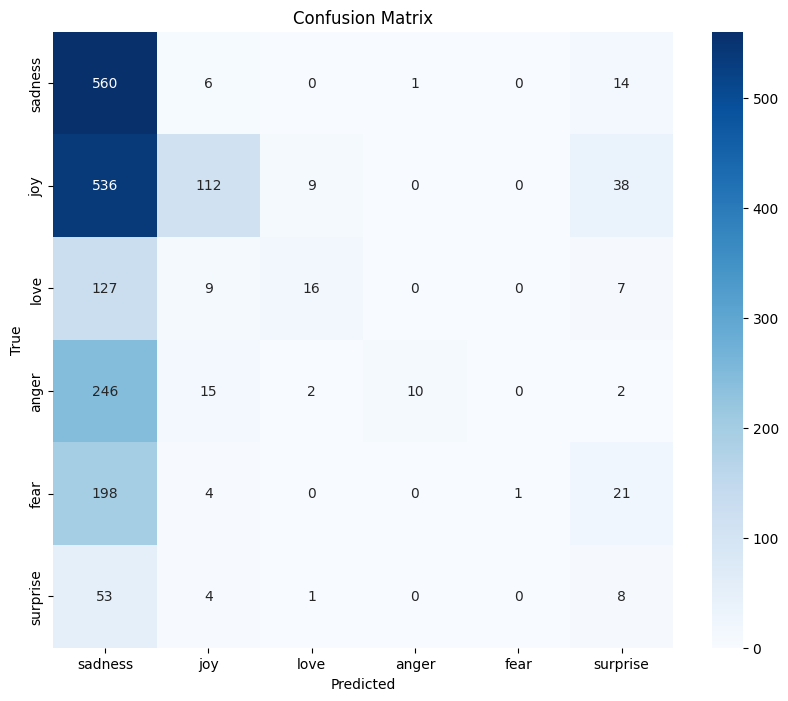

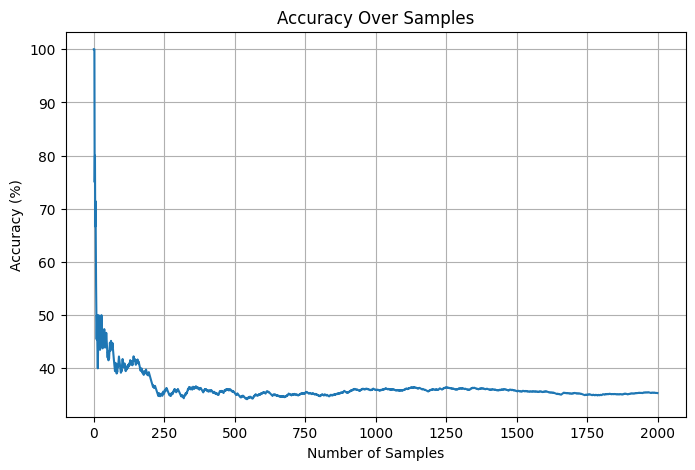

In [9]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Zero-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

# GPT-Neo CARER ChatGPT Prompt
This portion of the notebook will prompt a pretrained GPT-Neo on Contextualized Affect Representations for Emotion Recognition (CARER)  dataset using prompt generated by ChatGPT.

In [3]:
emotions = dataset.features["label"].names
print("Emotion categories:", emotions)

def classify_review(text):
    prompt = f"Classify the emotion in this text as one of {', '.join(emotions)}: '{text}'\nEmotion:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]
    emotion_ids = [tokenizer.encode(emotion, add_special_tokens=False)[0] for emotion in emotions]

    probabilities = torch.softmax(logits, dim=-1)
    emotion_probs = {emotion: probabilities[emotion_id].item() for emotion, emotion_id in zip(emotions, emotion_ids)}

    return max(emotion_probs, key=emotion_probs.get)

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset):
    text = sample["text"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(text)
    predicted_labels.append(emotions.index(predicted_label))

    if i % 100 == 0:
        print(f"Processed {i} samples...")

Emotion categories: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...


Zero-shot accuracy on the CARER dataset: 29.20%
Classification Report:
              precision    recall  f1-score   support

     sadness       0.29      1.00      0.45       581
         joy       1.00      0.00      0.01       695
        love       0.00      0.00      0.00       159
       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.29      2000
   macro avg       0.22      0.17      0.08      2000
weighted avg       0.43      0.29      0.13      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


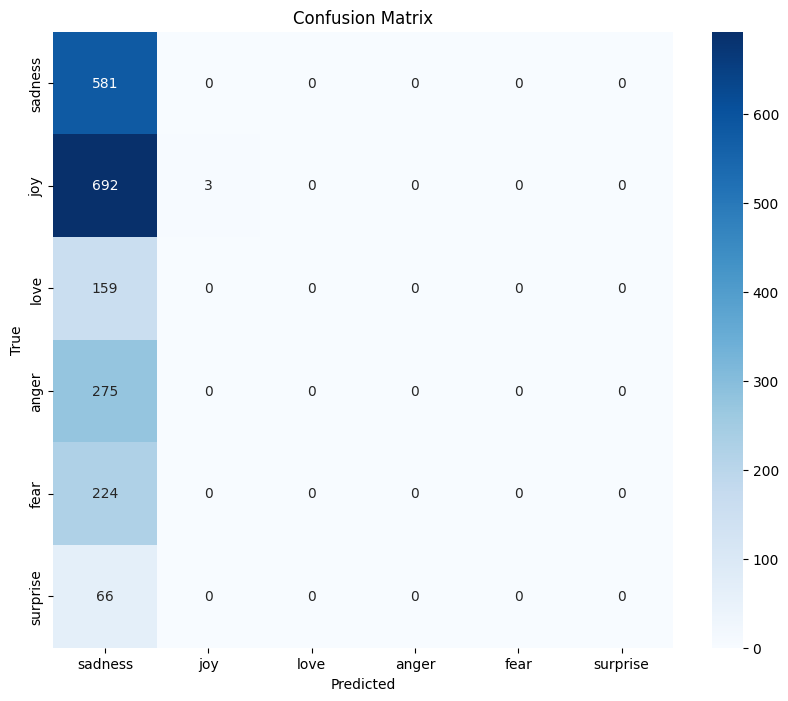

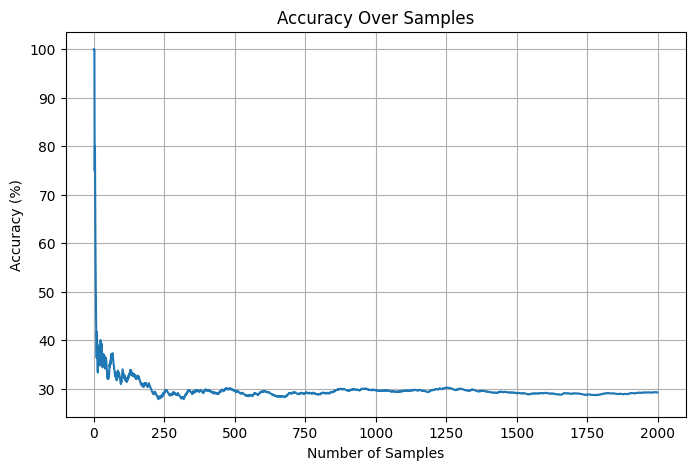

In [4]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Zero-shot accuracy on the CARER dataset: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotions))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()